# Test technique: Stage Data scientist Alexandra Amani 

Dans ce notebook vous trouverez differentes analyses menées sur des profils professionels de candidats à des postes dans la data

Sommaire : 

       1.Analyse exploratoire des données
       2.Clustering : Identification de groupes de profils
       3.Prediction du metier d'un candidat

**Import des librairies et des données**

In [8]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from plotnine import *
import plotnine

from kmodes.kmodes import KModes

from sklearn.metrics import classification_report
from  xgboost import XGBClassifier,plot_importance
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [9]:
pd.set_option('display.max_columns', 500)

In [10]:
sns.set(rc={'figure.figsize':(20,11)})

In [11]:
candidats = pd.read_csv("./data.csv")

In [12]:
candidats

Entreprise               Metier  \
0                                                Sanofi       Data scientist   
1                   Massachusetts General Hospital(MGH)      Data architecte   
2                                                 Delve  Lead data scientist   
3     Ann & Robert H. Lurie Children’s Hospital of C...       Data scientist   
4                                                   Arm       Data scientist   
...                                                 ...                  ...   
9577                Massachusetts General Hospital(MGH)       Data scientist   
9578                            Charles River Analytics       Data scientist   
9579                                     Ball Aerospace       Data scientist   
9580                              Takeda Pharmaceutical       Data scientist   
9581                                             Vertex       Data scientist   

                                           Technologies Diplome Experience  \
0         Matlab/Python/Pyspark/Scikit-learn/Tensorflow  Master          1   
1                             Python/Java/Scala/MongoDB  Master          3   
2     SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...  Master          3   
3                                     C/C++/Java/Python  Master        1,5   
4       Matlab/Python/C++/numpy/Tensorflow/scikit-learn     Phd        NaN   
...                                                 ...     ...        ...   
9577                     C++/R/Python/Matlab/Matplotlib  Master        1,5   
9578     Excel/Python/Matlab/R/machine learning/anglais  Master         11   
9579                       R/machine learning/Excel/VBA  Master          1   
9580    Python/Pyspark/machine learning/Microsoft Azure  Master         17   
9581                                 VBA/Python/Excel/R     Phd          0   

          Ville  
0         Paris  
1     Marseille  
2        Nantes  
3     Marseille  
4      Bordeaux  
...         ...  
9577       Lyon  
9578   Toulouse  
9579      Paris  
9580     Rennes  
9581      Paris  

[9582 rows x 6 columns]

## 1. Analyse exploratoire des données

Il ya 9582 observation dans le data set

In [13]:
candidats.shape

(9582, 6)

In [14]:
candidats.dtypes

Entreprise      object
Metier          object
Technologies    object
Diplome         object
Experience      object
Ville           object
dtype: object

In [15]:
candidats['Experience'] = candidats['Experience'].str.replace(',', '').astype(float)

Il ya au total 130 valeurs manquantes reparties

Par variable:

In [16]:
candidats.isna().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64

Par metier et variable:

In [17]:
candidats.drop(columns = 'Metier').isna().groupby(candidats.Metier, sort=False).sum().reset_index()

Metier  Entreprise  Technologies  Diplome  Experience  Ville
0       Data scientist           5             0        0          32      0
1      Data architecte           4             0        0          23      0
2  Lead data scientist           4             0        0          19      0
3        Data engineer           4             0        0          20      0

### Imputation des valeurs manquantes de l'experience par la valeur mediane pour les data scientists et par la valeur moyennne pour les autres metiers

In [18]:
candidats.loc[candidats["Metier"] == "Data scientist", "Experience"] = candidats.loc[candidats["Metier"] == "Data scientist", "Experience"].fillna(candidats[candidats["Metier"] == "Data scientist"].Experience.median())
candidats.loc[candidats["Metier"] == "Data engineer", "Experience"] = candidats.loc[candidats["Metier"] == "Data engineer", "Experience"].fillna(candidats[candidats["Metier"] == "Data engineer"].Experience.mean())

candidats.loc[candidats["Metier"] == "Lead data scientist", "Experience"] = candidats.loc[candidats["Metier"] == "Lead data scientist", "Experience"].fillna(candidats[candidats["Metier"] == "Lead data scientist"].Experience.mean())
candidats.loc[candidats["Metier"] == "Data architecte", "Experience"] = candidats.loc[candidats["Metier"] == "Data architecte", "Experience"].fillna(candidats[candidats["Metier"] == "Data architecte"].Experience.mean())

In [19]:
candidats.drop(columns = 'Metier').isna().groupby(candidats.Metier, sort=False).sum().reset_index()

Metier  Entreprise  Technologies  Diplome  Experience  Ville
0       Data scientist           5             0        0           0      0
1      Data architecte           4             0        0           0      0
2  Lead data scientist           4             0        0           0      0
3        Data engineer           4             0        0           0      0

### Proportion de candidats et experience moyenne par métier

In [20]:
candidats["Metier"].value_counts(dropna = False)

Data scientist         3865
Data engineer          2347
Data architecte        2123
Lead data scientist    1228
NaN                      19
Name: Metier, dtype: int64

In [21]:
candidats.groupby("Metier")["Experience"].mean()

Metier
Data architecte         9.977619
Data engineer           9.865492
Data scientist          8.410091
Lead data scientist    13.575682
Name: Experience, dtype: float64

In [22]:
candidats.groupby("Metier")["Experience"].describe()

count       mean        std  min  25%  50%   75%   max
Metier                                                                      
Data architecte      2123.0   9.977619  11.181898  0.0  2.0  5.0  15.0  35.0
Data engineer        2347.0   9.865492  11.012062  0.0  2.0  5.0  15.0  35.0
Data scientist       3865.0   8.410091   9.797470  0.0  2.0  5.0  15.0  35.0
Lead data scientist  1228.0  13.575682  12.112597  0.0  4.0  7.0  25.0  35.0

<AxesSubplot:xlabel='Metier', ylabel='Experience'>

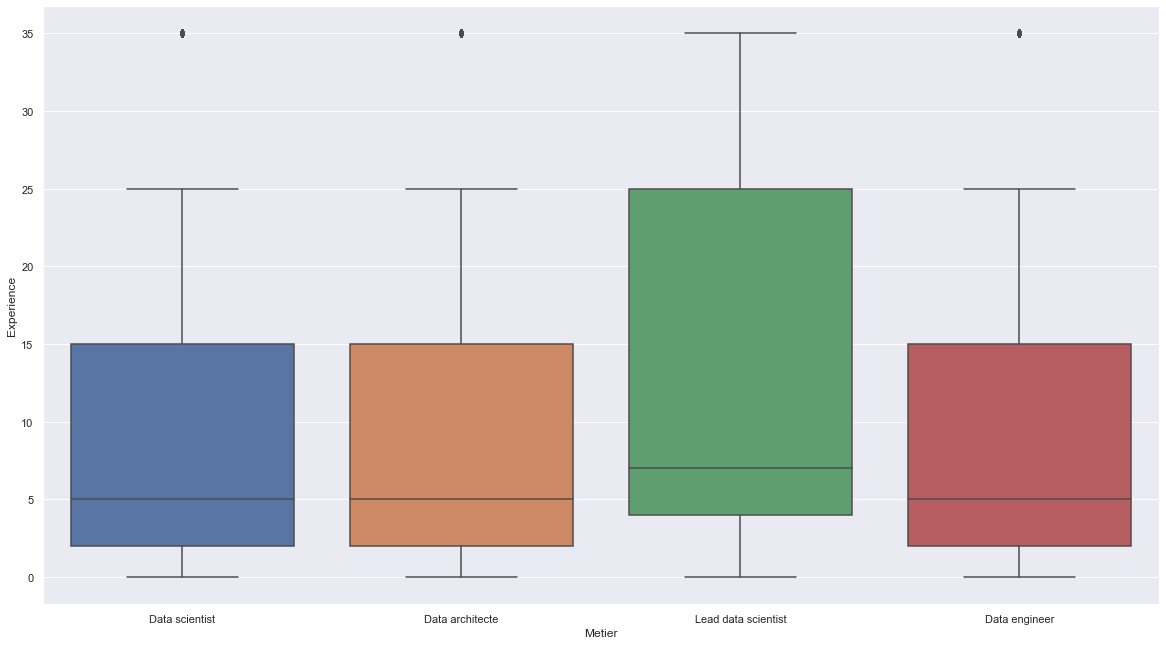

In [23]:
sns.boxplot(data=candidats ,y= "Experience", x="Metier" )

Commentaire : 

On remarque grâce aux boites à moustaches et aux statistiques descriptives que en moyenne l'expérience est similaire chez les data scientists , engineers et architectes. Les Lead data scientists ont en moyenne plus d'expérience 13 ans contre 8 et 9 ans. 

De même, les quartiles de l'expérience sont similaires chez les data scientists, engineers et architectes. 

Pour transformer variable Expérience, en variable qualitative, l'on tiendra compte du nombre d'annnées (quartiles) d'expérience pour assurer une homogéneité entre les groupes et du métier :

- Pour les data scientists, engineers et architectes 
    - débutant < 2 ans
    - confirmé entre 2 et 5 ans
    - avancé entre 5 et 15 ans 
    - expert > 15 ans
- Pour les lead data scientist
    - débutant < 4 ans
    - confirmé entre 4 et 7 ans
    - avancé entre 7 et 25 ans 
    - expert > 25 ans 

In [24]:
# Creation de Exp_label pour les data scientists, engineers et architectes
metiers_juniors = ["Data scientist", "Data engineer", "Data architecte"]

candidats.loc[(candidats["Metier"].isin(metiers_juniors)) & (candidats["Experience"] < 2),"Exp_label"] = "debutant"
candidats.loc[(candidats["Metier"].isin(metiers_juniors)) & (candidats["Experience"].between(2,5, inclusive = 'left')),"Exp_label"] = "confirme"
candidats.loc[(candidats["Metier"].isin(metiers_juniors)) & (candidats["Experience"].between(5,15, inclusive = 'left')),"Exp_label"] = "avance"
candidats.loc[(candidats["Metier"].isin(metiers_juniors)) & (candidats["Experience"]>= 15),"Exp_label"] = "expert"

In [25]:
# Creation de Exp_label pour les Lead data scientist
candidats.loc[(candidats["Metier"] ==  "Lead data scientist") & (candidats["Experience"] < 4),"Exp_label"] = "debutant"
candidats.loc[(candidats["Metier"] ==  "Lead data scientist") & (candidats["Experience"].between(4,7, inclusive = 'left')),"Exp_label"] = "confirme"
candidats.loc[(candidats["Metier"] ==  "Lead data scientist") & (candidats["Experience"].between(7,25, inclusive = 'left')),"Exp_label"] = "avance"
candidats.loc[(candidats["Metier"] ==  "Lead data scientist") & (candidats["Experience"]>= 25),"Exp_label"] = "expert"

In [26]:
candidats.groupby(['Metier','Exp_label']).agg({"Experience": "mean", "Exp_label" : "count" })

Experience  Exp_label
Metier              Exp_label                       
Data architecte     avance       6.651359        578
                    confirme     3.174312        436
                    debutant     0.514463        484
                    expert      25.128000        625
Data engineer       avance       6.534009        656
                    confirme     3.094949        495
                    debutant     0.565049        515
                    expert      25.029369        681
Data scientist      avance       5.707778        900
                    confirme     2.471976       1017
                    debutant     0.495238        840
                    expert      22.055957       1108
Lead data scientist avance      10.325817        230
                    confirme     4.957447        282
                    debutant     2.427632        304
                    expert      29.514563        412

### Technologies utilisées

Les 5 technologies les plus utilisées sont **python, r, sql, java et hadoop**

In [27]:
# Creation d'un data frame qui contient pour chaque technologie, le nombre de candidats qui l'utilise
technologies = candidats["Technologies"].str.lower().str.get_dummies(sep='/').sum().sort_values(ascending = False).reset_index()
technologies.columns = ['tech','number_users']
technologies

tech  number_users
0             python          6627
1                  r          4374
2                sql          2581
3               java          1719
4             hadoop          1589
5   machine learning          1454
6              excel          1398
7                c++          1381
8              spark          1240
9              linux          1183
10           mongodb          1166
11               vba          1003
12               sas           943
13            docker           927
14            matlab           871
15              hive           864
16        tensorflow           848
17     elasticsearch           826
18          big data           824
19      scikit-learn           789
20                 c           739
21            kibana           728
22               aws           691
23               gnu           677
24          teradata           610
25           anglais           603
26           pyspark           593
27              hdfs           361
28              spss           359
29   microsoft azure           338
30           mariadb           335
31             scala           310
32         cassandra           284
33        matplotlib           273
34           scoring           250
35           vertica           250
36           tableau           250
37                ai           250
38           pycharm           235
39             kafka           235
40             nosql           232
41     deep learning           227
42        postgresql           208
43              yarn           206
44               pig           155
45        map-reduce           155
46             hbase           155
47             numpy           140
48          redshift           124
49              nosq           123
50      hadoop(hdfs)            98
51            oracle            94
52             mysql            94
53           windows            75
54              perl            74
55              ruby            35

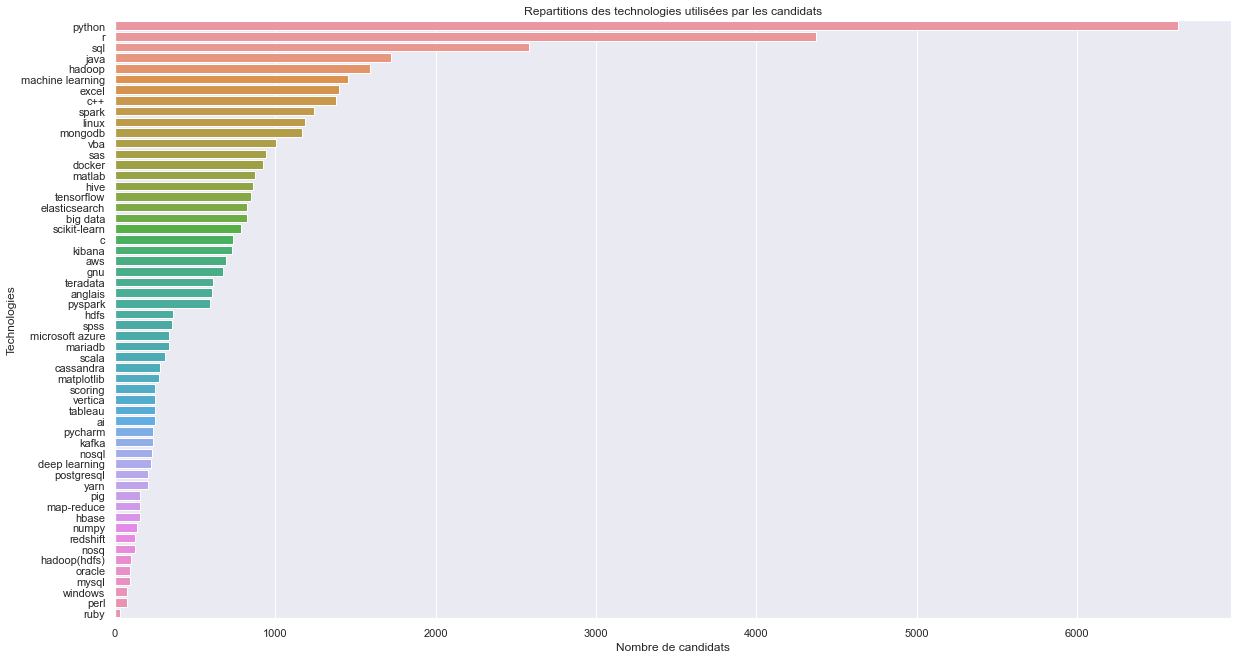

In [28]:
ax = sns.barplot(x= 'number_users', y="tech", data=technologies)
ax.set(xlabel='Nombre de candidats', ylabel='Technologies')
ax.set_title('Repartitions des technologies utilisées par les candidats')
plt.show()

In [29]:
# Creation d'un dataframe contenant les dummies des technologies
candidats_tech_dum = pd.concat([candidats, candidats["Technologies"].str.lower().str.get_dummies(sep='/')], axis=1)

In [30]:
candidats_tech_dum.drop(columns = "Experience").groupby(['Metier']).sum()*100/candidats_tech_dum.shape[0]

ai   anglais       aws  big data         c  \
Metier                                                                  
Data architecte      0.000000  0.000000  6.449593  0.000000  0.939261   
Data engineer        0.000000  0.000000  0.751409  0.000000  2.128992   
Data scientist       2.327280  3.892716  0.000000  5.719057  3.746608   
Lead data scientist  0.281778  2.358589  0.000000  2.880401  0.887080   

                          c++  cassandra  deep learning    docker  \
Metier                                                              
Data architecte      0.939261   1.335838       0.000000  4.299729   
Data engineer        2.128992   1.607180       0.000000  5.374661   
Data scientist       9.183886   0.000000       2.212482  0.000000   
Lead data scientist  2.128992   0.000000       0.146107  0.000000   

                     elasticsearch      excel       gnu    hadoop  \
Metier                                                              
Data architecte           4.299729   0.000000  1.189731  6.741808   
Data engineer             4.320601   0.000000  5.865164  5.385097   
Data scientist            0.000000  12.085160  0.000000  2.556877   
Lead data scientist       0.000000   2.462951  0.000000  1.857650   

                     hadoop(hdfs)    hbase      hdfs      hive      java  \
Metier                                                                     
Data architecte          1.022751  0.00000  0.000000  3.882279  6.908787   
Data engineer            0.000000  1.60718  3.757044  2.880401  8.286370   
Data scientist           0.000000  0.00000  0.000000  0.521812  2.254227   
Lead data scientist      0.000000  0.00000  0.000000  1.701106  0.480067   

                        kafka    kibana     linux  machine learning  \
Metier                                                                
Data architecte      2.452515  3.276978  3.746608          0.000000   
Data engineer        0.000000  4.320601  8.578585          0.000000   
Data scientist       0.000000  0.000000  0.000000         11.323315   
Lead data scientist  0.000000  0.000000  0.000000          3.788353   

                     map-reduce   mariadb    matlab  matplotlib  \
Metier                                                            
Data architecte         0.00000  0.000000  0.000000    0.000000   
Data engineer           1.60718  3.496139  0.000000    0.000000   
Data scientist          0.00000  0.000000  7.441035    2.348153   
Lead data scientist     0.00000  0.000000  1.638489    0.500939   

                     microsoft azure   mongodb     mysql      nosq     nosql  \
Metier                                                                         
Data architecte             0.000000  4.863285  0.000000  0.000000  1.335838   
Data engineer               0.000000  6.219996  0.981006  1.283657  0.000000   
Data scientist              2.828220  0.824463  0.000000  0.000000  0.824463   
Lead data scientist         0.688791  0.250470  0.000000  0.000000  0.250470   

                        numpy    oracle      perl      pig  postgresql  \
Metier                                                                   
Data architecte      0.000000  0.000000  0.407013  0.00000    0.000000   
Data engineer        0.000000  0.981006  0.354832  1.60718    2.170737   
Data scientist       1.241912  0.000000  0.000000  0.00000    0.000000   
Lead data scientist  0.219161  0.000000  0.000000  0.00000    0.000000   

                      pycharm   pyspark     python          r  redshift  \
Metier                                                                    
Data architecte      0.000000  0.000000  10.697140   0.000000  1.294093   
Data engineer        0.000000  1.784596  12.325193   0.000000  0.000000   
Data scientist       2.003757  3.673555  34.168232  34.105615  0.000000   
Lead data scientist  0.438322  0.720100  11.813818  11.427677  0.000000   

                         ruby       sas     scala  scikit-learn   scoring  \
Metier           

Le tableau ci dessus présente la proportion de quandidats utilisants chaque technologie par metier. 
Ex : 2.33 % des candidats ont 'ai' comme compétence et ce sont des data scientists.

Les technologies selectionnées pour le clustering sont celles les plus utilisées par les candidats en general (python, R, sql) et par chaque metier. Par exemple,  7 % des candidats ont 'big data' comme compétence et ce sont uniquement des Lead/data scientists. 

Les technologies choisies sont : 

    "aws","big data", "c++", "docker","excel", "gnu","hadoop","java","linux",
    
    "machine learning","matlab","mongodb","python","r","sas","scikit-learn",
    
    "spark","sql","tensorflow","vba","elasticsearch","hdfs" ,"vertica","yarn"

In [31]:
candidats_diplome = candidats.groupby(['Metier'])['Diplome'].value_counts(normalize = True).round(2).reset_index(name ='proportion')

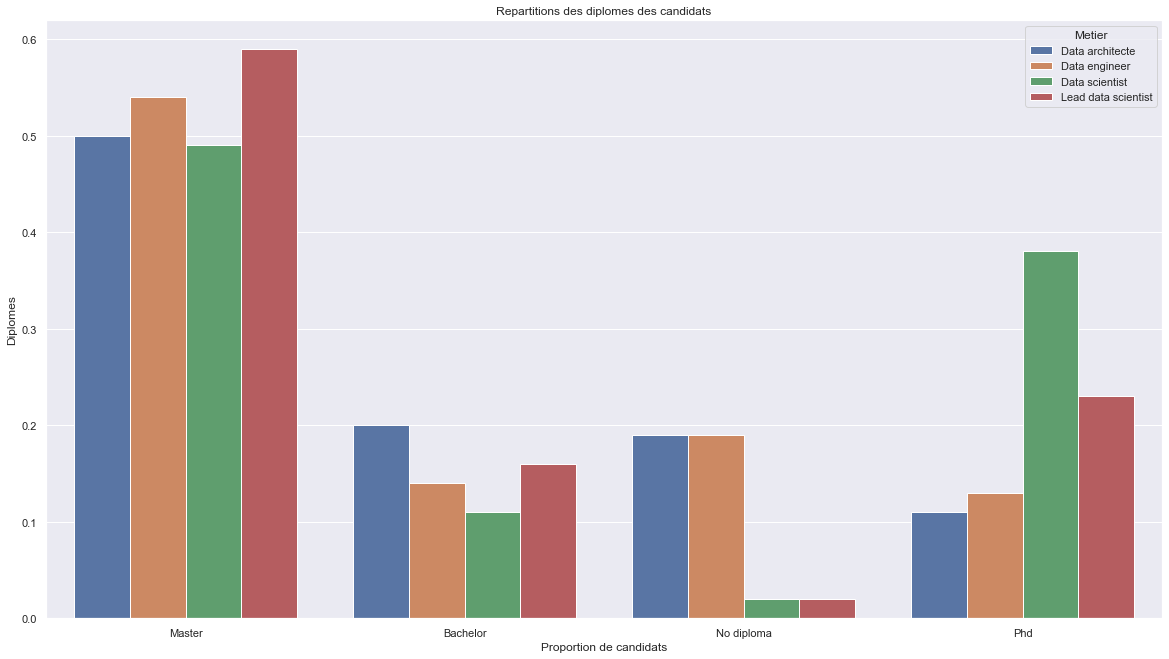

In [32]:
ax = sns.barplot(x= 'Diplome', y="proportion", hue = "Metier", data=candidats_diplome)
ax.set(xlabel='Proportion de candidats', ylabel='Diplomes')
ax.set_title('Repartitions des diplomes des candidats')
plt.show()

## 2.Clustering : Identification de groupes de profils

In [33]:
# Variables utilisées pour les clustering
clustering_variables = [
    "Exp_label", "Diplome", "Metier","aws","big data", "c++", 
    "docker","excel", "gnu","hadoop","java","linux","machine learning",
    "matlab","mongodb","python","r","sas","scikit-learn","spark",
    "sql","tensorflow","vba","elasticsearch","hdfs" ,"vertica","yarn"
]

In [34]:
#Tables  utilisée pour le clustering
candidats_clustering = candidats_tech_dum[clustering_variables]
#On garde les candidats qui ont un metier renseigné
candidats_clustering = candidats_clustering[candidats_clustering['Metier'].isna() == False]

In [35]:
candidats_clustering = candidats_clustering.astype(str)

In [36]:
#Transformation du data frame en matrix pour kmodes
candidats_matrix = candidats_clustering.to_numpy()

Comme méthode de clustering j'utilise la methode K-modes qui es une methode développée à partir des K-means mais adaptée et efficace pour les variables qualitatives ou mixtes. 

Différence avec les Kmeans :

- la distance entre deux points X et Y est le nombre d'observations de X et Y qui ont des valeurs différentes. 
- les moyennes sont changées par les modes.
- on utilise la fréquence pour chercher les centroids : pour chque variable la catégorie la plus fréquente est considérée comme centroid.

Le nombre optimal de cluster est choisi par la méthode du coude avec la difference intra cluster. 

In [37]:
# Nombre obtimal de clusters K
cost = []
for cluster in range(1, 11):
    try:
        kmodes = KModes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kmodes.fit_predict(candidats_matrix)
        cost.append(kmodes.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Cluster initiation: 10


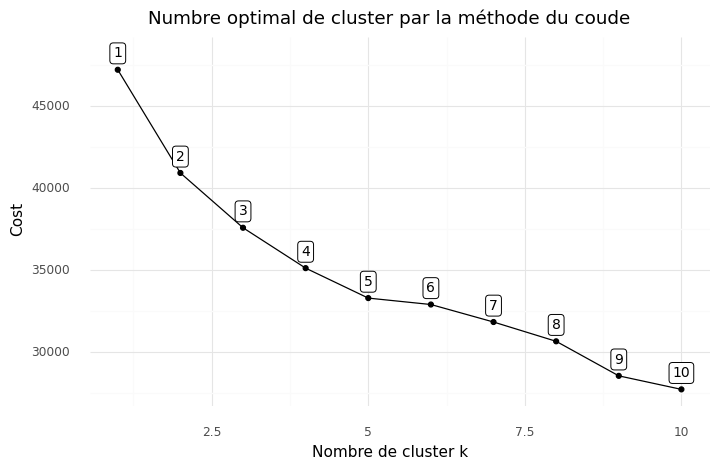

<ggplot: (199198766550)>

In [38]:
df_cost = pd.DataFrame({'Cluster': range(1, 11), 'Cost': cost})

# Représentaion de la differnece intra cluster en fonction du nobre de clusters
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Numbre optimal de cluster par la méthode du coude')+
    xlab('Nombre de cluster k')+
    ylab('Cost')+
    theme_minimal()
)

On choisi 5 clsuters.

In [39]:
# Fit et prediction des cluster
kmodes = KModes(n_jobs = -1, n_clusters = 5, init = 'Huang', random_state = 0)
cluster_predictions = kmodes.fit_predict(candidats_matrix)

**Analyse des centroids des clusters**

In [40]:
pd.DataFrame(kmodes.cluster_centroids_, columns = candidats_clustering.columns)

Exp_label Diplome           Metier aws big data c++ docker excel gnu hadoop  \
0    expert  Master   Data scientist   0        0   0      0     0   0      0   
1    avance  Master  Data architecte   0        0   0      0     0   0      0   
2    expert  Master   Data scientist   0        0   0      0     1   0      0   
3    expert  Master    Data engineer   0        0   0      0     0   0      0   
4    expert  Master   Data scientist   0        0   0      0     0   0      0   

  java linux machine learning matlab mongodb python  r sas scikit-learn spark  \
0    0     0                0      0       0      1  1   0            0     0   
1    0     0                0      0       0      0  0   0            0     0   
2    0     0                1      0       0      1  1   0            0     0   
3    0     0                0      0       0      1  0   0            0     0   
4    0     0                0      0       0      1  1   0            1     0   

  sql tensorflow vba elasticsearch hdfs vertica yarn  
0   1          0   0             0    0       0    0  
1   0          0   0             0    0       0    0  
2   0          0   1             0    0       0    0  
3   0          0   0             0    0       0    0  
4   0          1   0             0    0       0    0

Comme on peut le voir dans la table au dessus :

    - Dans les clusters 0, 2 et 4 on retrouve en majorité des data scientists
    - Dans le cluster 1 on retrouve des data architectse en majorité
    - Dans le cluster 3 on retouve majoritairement des data engineers

In [41]:
candidats_clustering['Cluster Labels'] = kmodes.labels_

In [42]:
# Proportion de metier dans chaque cluster 
candidats_clustering.groupby(['Cluster Labels'])['Metier'].value_counts(normalize = True).to_frame()

Metier
Cluster Labels Metier                       
0              Data scientist       0.673631
               Lead data scientist  0.326369
1              Data architecte      0.658968
               Data engineer        0.303861
               Data scientist       0.027788
               Lead data scientist  0.009383
2              Data scientist       0.836705
               Lead data scientist  0.163295
3              Data engineer        0.694188
               Data architecte      0.136993
               Data scientist       0.134225
               Lead data scientist  0.034594
4              Data scientist       0.858323
               Lead data scientist  0.141677

**Visualisation des principales technologies utilisées par chaque profil**

In [43]:
df = candidats_clustering.drop(columns = ['Exp_label','Diplome','Metier']).astype(float)
df = df.groupby(['Cluster Labels']).sum().reset_index().transpose().reset_index()
df = df.iloc[1: , :]
df.columns = ['tech','cluster 0', 'cluster 1', 'cluster 2', 'cluster 3', 'cluster 4']
df

tech  cluster 0  cluster 1  cluster 2  cluster 3  cluster 4
1                aws        0.0      544.0        0.0      146.0        0.0
2           big data      583.0        0.0        0.0        0.0      241.0
3                c++      403.0      127.0      227.0      481.0      140.0
4             docker        0.0      649.0        0.0      278.0        0.0
5              excel        0.0       10.0     1384.0        0.0        0.0
6                gnu        0.0      223.0        0.0      453.0        0.0
7             hadoop      423.0      885.0        0.0      277.0        0.0
8               java      130.0      916.0        0.0      672.0        0.0
9              linux        0.0      496.0        0.0      685.0        0.0
10  machine learning      455.0       35.0      845.0      113.0        0.0
11            matlab      273.0       39.0      144.0      143.0      271.0
12           mongodb      103.0      801.0        0.0      261.0        0.0
13            python     2393.0      821.0      707.0     1844.0      847.0
14                 r     2393.0       10.0     1384.0        0.0      576.0
15               sas      689.0        3.0      247.0        0.0        0.0
16      scikit-learn        0.0       39.0        0.0      143.0      606.0
17             spark      444.0      166.0        0.0      627.0        0.0
18               sql     1990.0      395.0        0.0       82.0      109.0
19        tensorflow        0.0        0.0        0.0        0.0      847.0
20               vba        0.0        7.0      993.0        0.0        0.0
21     elasticsearch        0.0      710.0        0.0      116.0        0.0
22              hdfs        0.0      146.0        0.0      214.0        0.0
23           vertica        0.0      247.0        0.0        0.0        0.0
24              yarn        0.0      146.0        0.0       60.0        0.0

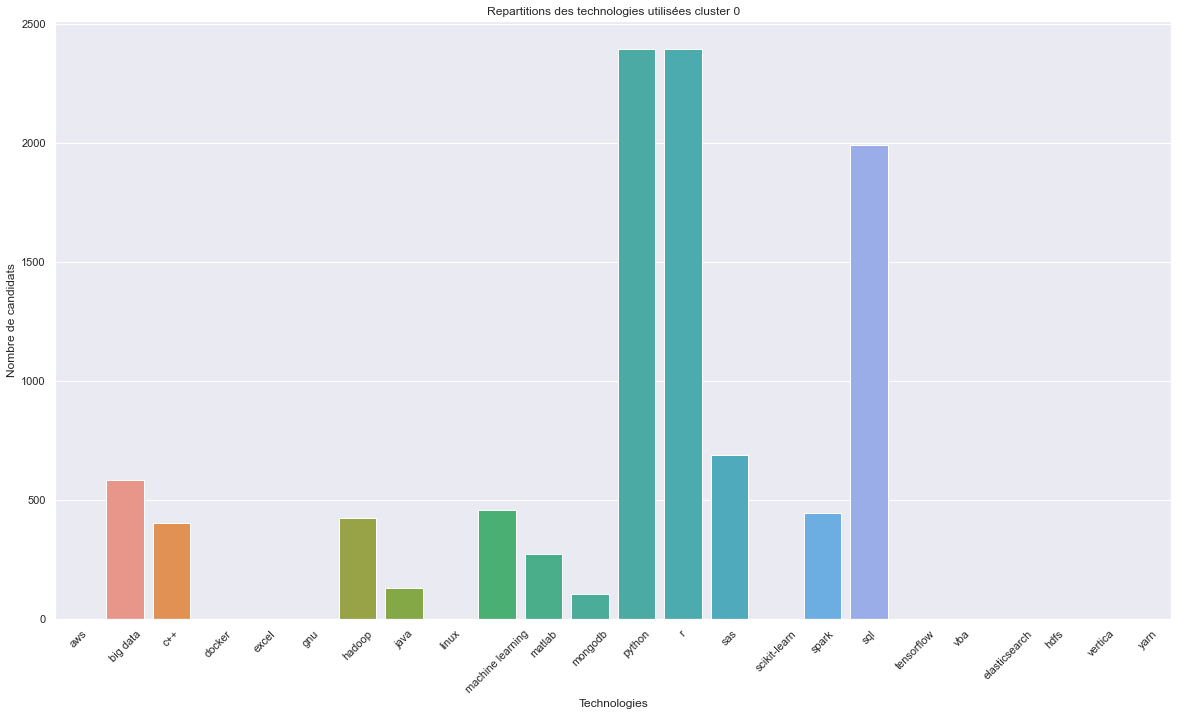

In [44]:
ax = sns.barplot(x= 'tech',y='cluster 0', data=df)
ax.set(ylabel='Nombre de candidats', xlabel='Technologies')
ax.set_title('Repartitions des technologies utilisées cluster 0')
plt.xticks(rotation=45)
plt.show()

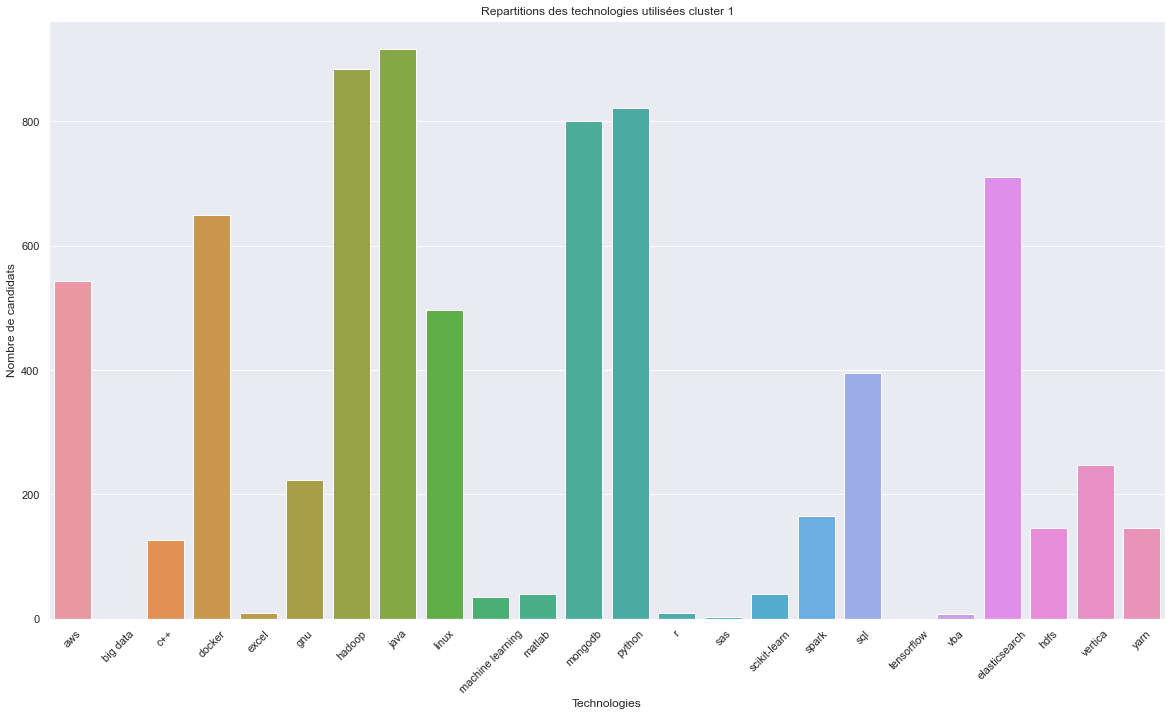

In [45]:
ax = sns.barplot(x= 'tech',y='cluster 1', data=df)
ax.set(ylabel='Nombre de candidats', xlabel='Technologies')
ax.set_title('Repartitions des technologies utilisées cluster 1')
plt.xticks(rotation=45)
plt.show()

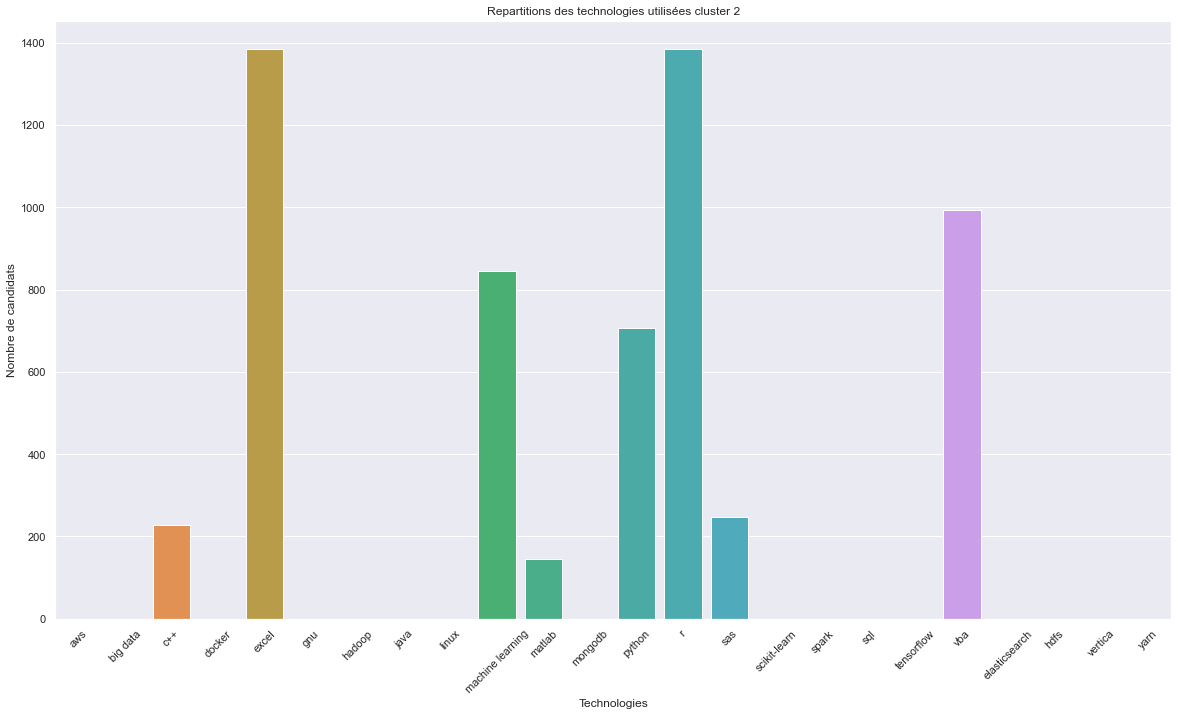

In [46]:
ax = sns.barplot(x= 'tech',y='cluster 2', data=df)
ax.set(ylabel='Nombre de candidats', xlabel='Technologies')
ax.set_title('Repartitions des technologies utilisées cluster 2')
plt.xticks(rotation=45)
plt.show()

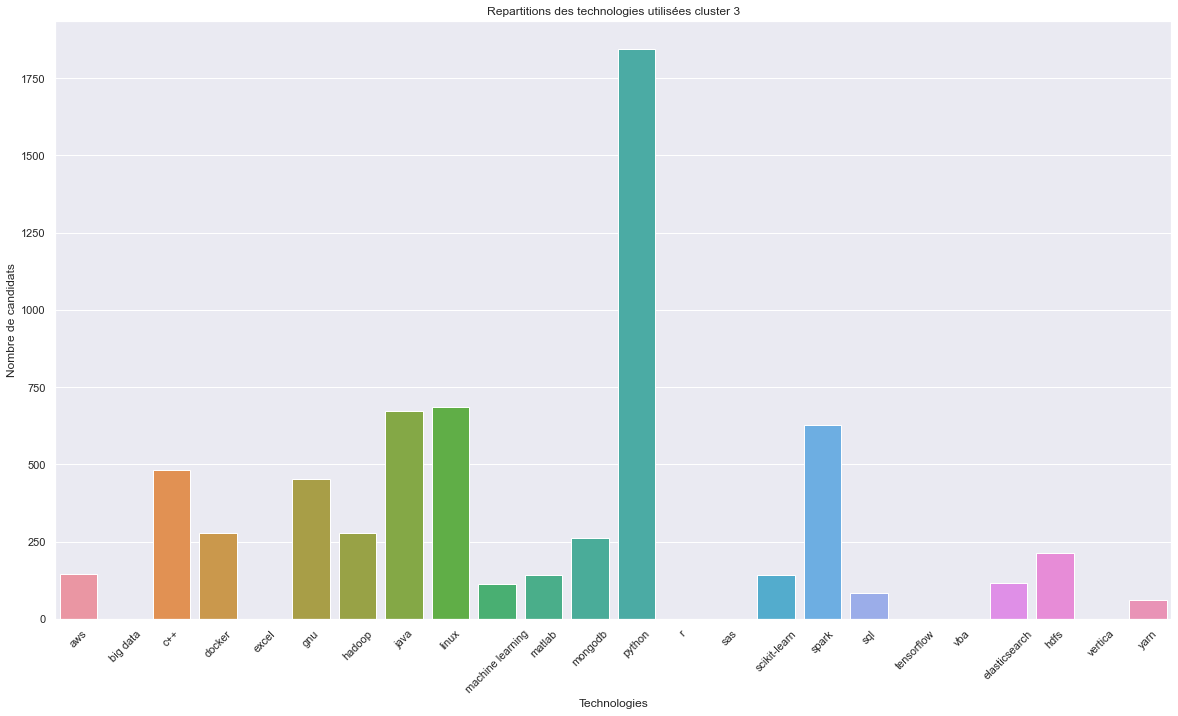

In [47]:
ax = sns.barplot(x= 'tech',y='cluster 3', data=df)
ax.set(ylabel='Nombre de candidats', xlabel='Technologies')
ax.set_title('Repartitions des technologies utilisées cluster 3')
plt.xticks(rotation=45)
plt.show()

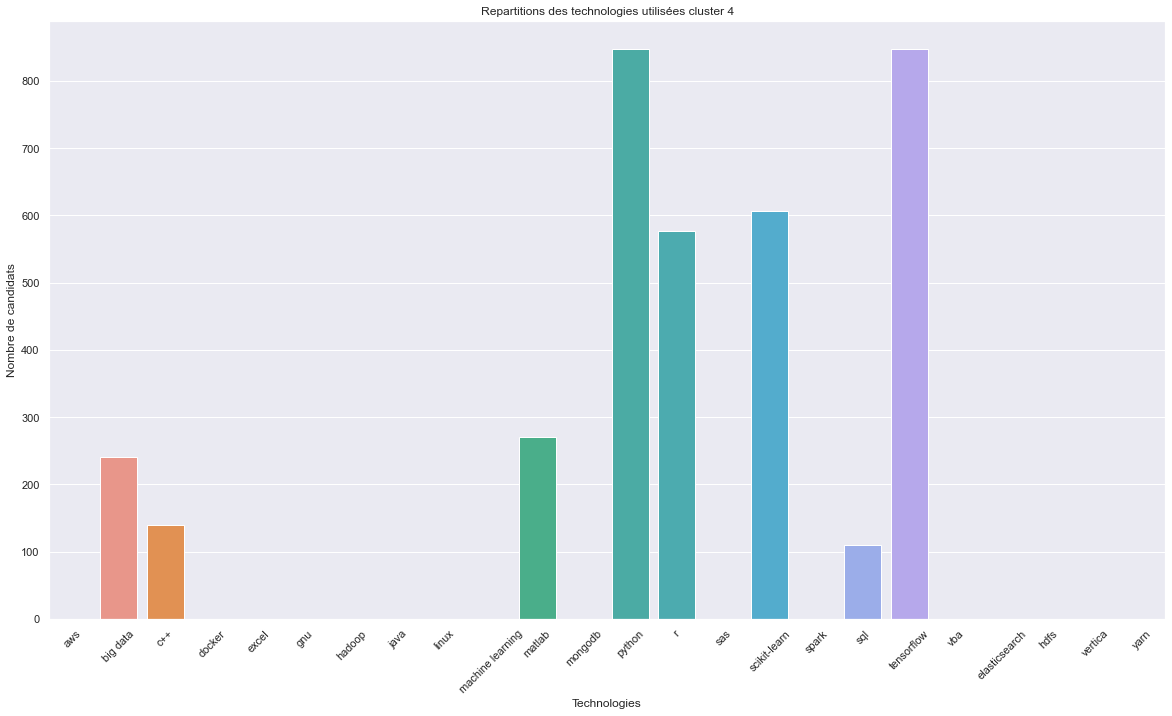

In [48]:
ax = sns.barplot(x= 'tech',y='cluster 4', data=df)
ax.set(ylabel='Nombre de candidats', xlabel='Technologies')
ax.set_title('Repartitions des technologies utilisées cluster 4')
plt.xticks(rotation=45)
plt.show()

**Commentaire** : 

Dans le premier cluster 0 on retrouve uniquement des data scientits et Lead candidats qui utilisent pricipalement python, R, et SQL.  

Le cluster 1 est composé de data architectes, de data engineers et de très peu de data scientists (et Lead). On y retrouve des compétences techniques, informatiques (linux, c++, hadoop, java) , très peu de machine learning et pas d'analyse (SAS, R)

Le Cluster2 formé de data scientists et Lead data scientists uniquement. Ils ont des profils d'analystes (excel, vba, R) et très peu de compétences informatiques (linux, java).

Le cluster 3 est formé de data enginer majoritairement (63%),  de data scientists, de data architectes et de très peu de Lead. Ils utilisent principalement Python et des technologies informatiques.

Le cluster 4 est formé de data scientits et de Lead qui utilisent principalement R, python scikit-learn et tensorflow.

## 3. Prédiction du métier d 'un candidat

In [49]:
#Transformation des varibles diplome et Exp_label en dummy
cols_drop = ["Entreprise","Technologies","Metier","Experience","Ville"]

candidats_clean_pred = candidats_tech_dum[candidats_tech_dum['Metier'].isna() == False]

candidats_clean_pred = pd.get_dummies(candidats_clean_pred, columns=["Diplome","Exp_label"], drop_first = True)

#Transformation des metiers en facteurs
candidats_clean_pred['Metier_num']= pd.factorize(candidats_clean_pred['Metier'])[0]
print(f"Facteurs des metiers : [0,1,2,3] \n {pd.factorize(candidats_clean_pred['Metier'])[1]}")
labels = pd.factorize(candidats_clean_pred['Metier'])[1]
#Table pour la prediction
candidats_clean_pred = candidats_clean_pred.drop(columns = cols_drop)
candidats_clean_pred = candidats_clean_pred.astype(float)

Facteurs des metiers : [0,1,2,3] 
 Index(['Data scientist', 'Data architecte', 'Lead data scientist',
       'Data engineer'],
      dtype='object')


In [50]:
# Création d'une base d'entrainement et de test
train_attributes, test_attributes, train_metier, test_metier = train_test_split(candidats_clean_pred.drop(columns = "Metier_num"), candidats_clean_pred['Metier_num'], test_size=.2)

### Random forest 

In [51]:
rand_forest = RandomForestClassifier(criterion = 'entropy')
rand_forest.fit(train_attributes,train_metier)
pred_rand_forest = rand_forest.predict(test_attributes)


In [52]:
print(classification_report(test_metier, pred_rand_forest))

              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85       748
         1.0       0.98      0.96      0.97       399
         2.0       0.61      0.30      0.40       260
         3.0       1.00      1.00      1.00       506

    accuracy                           0.87      1913
   macro avg       0.84      0.80      0.80      1913
weighted avg       0.86      0.87      0.85      1913



### extreme Gradient Boosting

In [54]:
xgb = XGBClassifier(objective= "multi:softmax")
xgb.fit(train_attributes,train_metier)
pred_xgb = xgb.predict(test_attributes)
print(classification_report(test_metier, pred_xgb))

              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85       748
         1.0       0.98      0.96      0.97       399
         2.0       0.62      0.29      0.39       260
         3.0       1.00      1.00      1.00       506

    accuracy                           0.87      1913
   macro avg       0.85      0.80      0.80      1913
weighted avg       0.86      0.87      0.85      1913



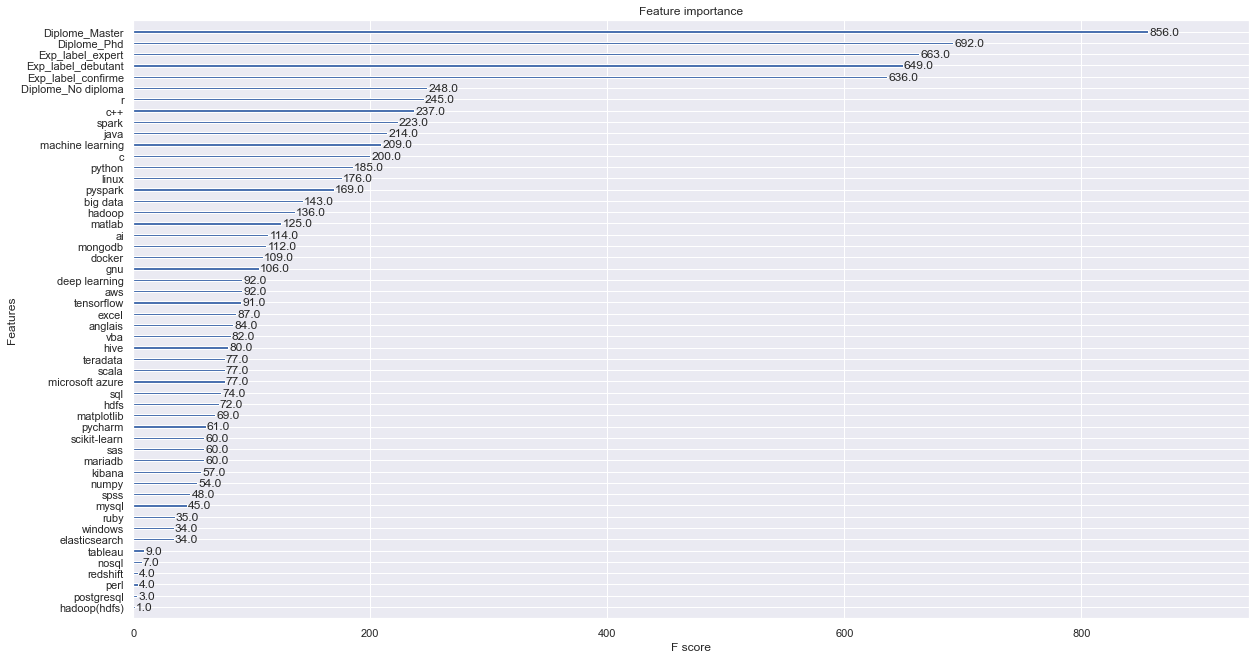

In [55]:
# plot feature importance
plot_importance(xgb)
plt.show()

On obtient des perfomances similaires entre le random forest et le xgboost. 

### Prédiction des metiers

**Mise en forme de la table contenant les candidats sans metiers**

In [56]:
candidats_sans_metier = candidats_tech_dum[candidats_tech_dum['Metier'].isna()]

In [57]:
#Création de la variabe expérience
candidats_sans_metier.loc[candidats_sans_metier["Experience"] < 2,"Exp_label"] = "debutant"
candidats_sans_metier.loc[candidats_sans_metier["Experience"].between(2,5, inclusive = 'left'),"Exp_label"] = "confirme"
candidats_sans_metier.loc[candidats_sans_metier["Experience"].between(5,15, inclusive = 'left'),"Exp_label"] = "avance"
candidats_sans_metier.loc[candidats_sans_metier["Experience"]>= 15,"Exp_label"] = "expert"

In [58]:
#Transformation des varibles diplome et Exp_label en dummy
cols_drop = ["Entreprise","Technologies","Metier","Experience","Ville"]
candidats_sans_metier_clean = pd.get_dummies(candidats_sans_metier, columns=["Diplome","Exp_label"], drop_first = True)
candidats_sans_metier_clean = candidats_sans_metier_clean.drop(columns = cols_drop)
candidats_sans_metier_clean

ai  anglais  aws  big data  c  c++  cassandra  deep learning  docker  \
346    0        0    0         0  0    0          0              0       0   
2058   0        0    0         0  0    0          0              0       0   
2670   0        0    0         0  1    1          0              0       0   
2899   0        0    0         0  0    0          0              1       0   
3346   0        0    1         0  0    0          1              0       0   
4248   0        0    0         0  0    0          0              0       0   
4290   0        1    0         0  0    0          0              0       0   
4292   0        1    0         0  0    0          0              0       0   
5425   0        0    0         0  0    0          0              0       0   
5593   0        0    0         0  0    1          0              0       0   
5712   0        0    0         0  0    0          0              0       0   
6024   0        0    0         0  0    0          0              0       0   
6625   0        0    0         0  0    0          0              0       0   
7091   0        1    0         0  0    0          0              0       0   
7228   0        0    0         0  0    0          1              0       0   
7330   0        1    0         0  0    0          0              0       0   
9087   0        0    0         0  0    0          0              0       0   
9427   0        0    0         0  0    1          0              0       0   
9490   0        0    0         0  0    0          0              0       0   

      elasticsearch  excel  gnu  hadoop  hadoop(hdfs)  hbase  hdfs  hive  \
346               0      0    1       0             0      0     0     0   
2058              0      1    0       0             0      0     0     0   
2670              0      0    0       0             0      0     0     0   
2899              0      0    0       0             0      0     0     0   
3346              0      0    0       0             0      0     0     0   
4248              0      0    0       0             0      0     0     0   
4290              0      0    0       0             0      0     0     0   
4292              0      0    0       0             0      0     0     0   
5425              0      0    0       0             0      0     0     0   
5593              0      1    0       0             0      0     0     0   
5712              0      0    0       1             0      0     0     1   
6024              0      0    0       1             0      0     0     0   
6625              0      0    0       1             0      0     0     1   
7091              0      0    0       0             0      0     0     0   
7228              0      0    0       0             0      1     1     0   
7330              0      1    0       0             0      0     0     0   
9087              0      0    0       1             0      0     0     1   
9427              0      1    0       0             0      0     0     0   
9490              0      0    0       0             0      0     0     0   

      java  kafka  kibana  linux  machine learning  map-reduce  mariadb  \
346      0      0       0      1                 0           0        0   
2058     0      0       0      0                 0           0        0   
2670     1      0       0      0                 0           0        0   
2899     0      0       0      0                 0           0        0   
3346     0      0       0      0                 0           0        0   
4248     0      0       0      0                 0           0        0   
4290     0      0       0      0                 1           0        0   
4292     0      0       0      0                 1           0        0   
5425     0      0       0      0                 0           0        0   
5593     0      0       0      0                 1           0        0   
5712     0      0       0      0                 0           0        0   
6024     0      0       

In [59]:
prediction_metier = xgb.predict(candidats_sans_metier_clean)
candidats_sans_metier_clean["Metier_predit"] = labels[prediction_metier]

In [60]:
candidats_sans_metier_clean["Metier_predit"]

346           Data engineer
2058         Data scientist
2670         Data scientist
2899         Data scientist
3346        Data architecte
4248         Data scientist
4290         Data scientist
4292         Data scientist
5425          Data engineer
5593         Data scientist
5712        Data architecte
6024          Data engineer
6625        Data architecte
7091    Lead data scientist
7228          Data engineer
7330         Data scientist
9087        Data architecte
9427         Data scientist
9490         Data scientist
Name: Metier_predit, dtype: object